In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (confusion_matrix, classification_report, 
                           roc_auc_score, roc_curve, precision_recall_curve,
                           accuracy_score, precision_score, recall_score, f1_score)
from imblearn.over_sampling import (SMOTE, BorderlineSMOTE, SVMSMOTE, 
                                   ADASYN, RandomOverSampler)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import KMeans
from imblearn.over_sampling import KMeansSMOTE

## 1. Загрузка данных

In [2]:
data = pd.read_csv('datas/CHD.csv')
print("Первые 5 строк данных:")
print(data.head())

Первые 5 строк данных:
   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0          

## 2. Анализ данных

2.1 Исследование зависимостей признаков

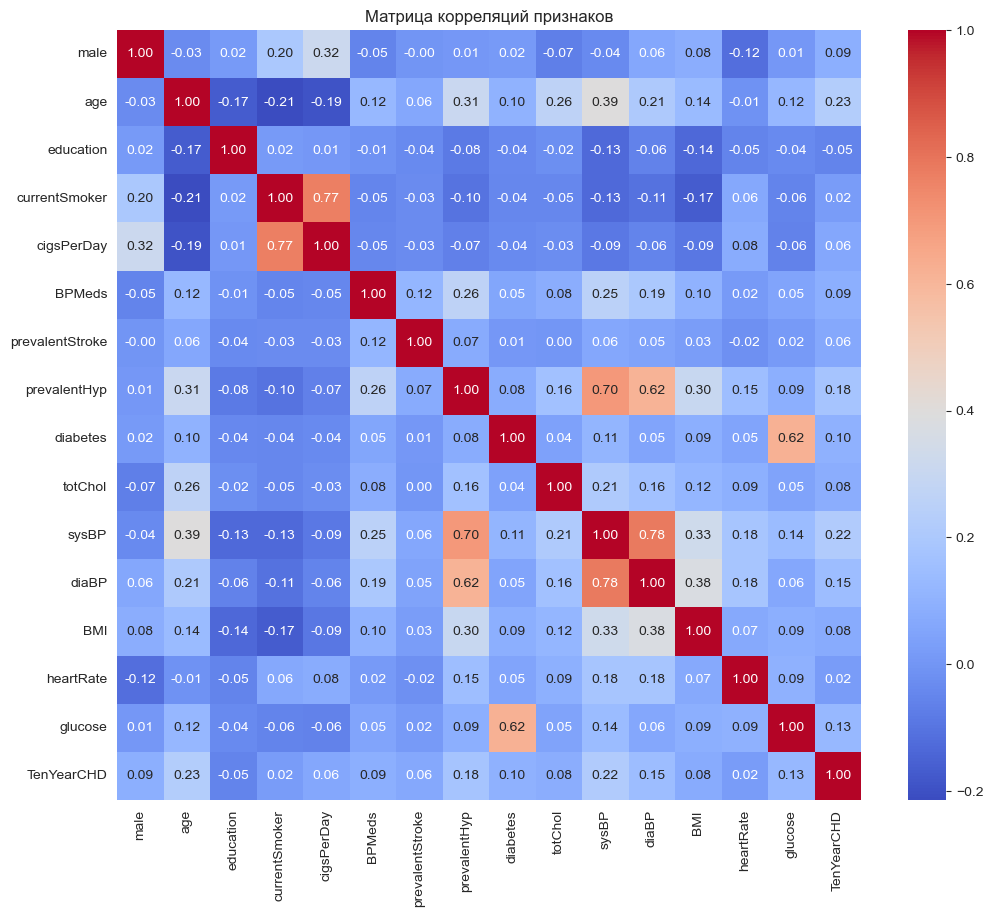

In [3]:
plt.figure(figsize=(12, 10))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Матрица корреляций признаков")
plt.show()

2.2 Проверка целостности данных

In [4]:
print("\nИнформация о данных:")
print(data.info())
print("\nПропущенные значения:")
print(data.isnull().sum())


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 

2.3 Статистический анализ каждого признака

In [5]:
print("\nОписательная статистика:")
print(data.describe(include='all'))


Описательная статистика:
              male          age    education  currentSmoker   cigsPerDay  \
count  4240.000000  4240.000000  4135.000000    4240.000000  4211.000000   
mean      0.429245    49.580189     1.979444       0.494104     9.005937   
std       0.495027     8.572942     1.019791       0.500024    11.922462   
min       0.000000    32.000000     1.000000       0.000000     0.000000   
25%       0.000000    42.000000     1.000000       0.000000     0.000000   
50%       0.000000    49.000000     2.000000       0.000000     0.000000   
75%       1.000000    56.000000     3.000000       1.000000    20.000000   
max       1.000000    70.000000     4.000000       1.000000    70.000000   

            BPMeds  prevalentStroke  prevalentHyp     diabetes      totChol  \
count  4187.000000      4240.000000   4240.000000  4240.000000  4190.000000   
mean      0.029615         0.005896      0.310613     0.025708   236.699523   
std       0.169544         0.076569      0.462799   

Анализ распределения каждого признака

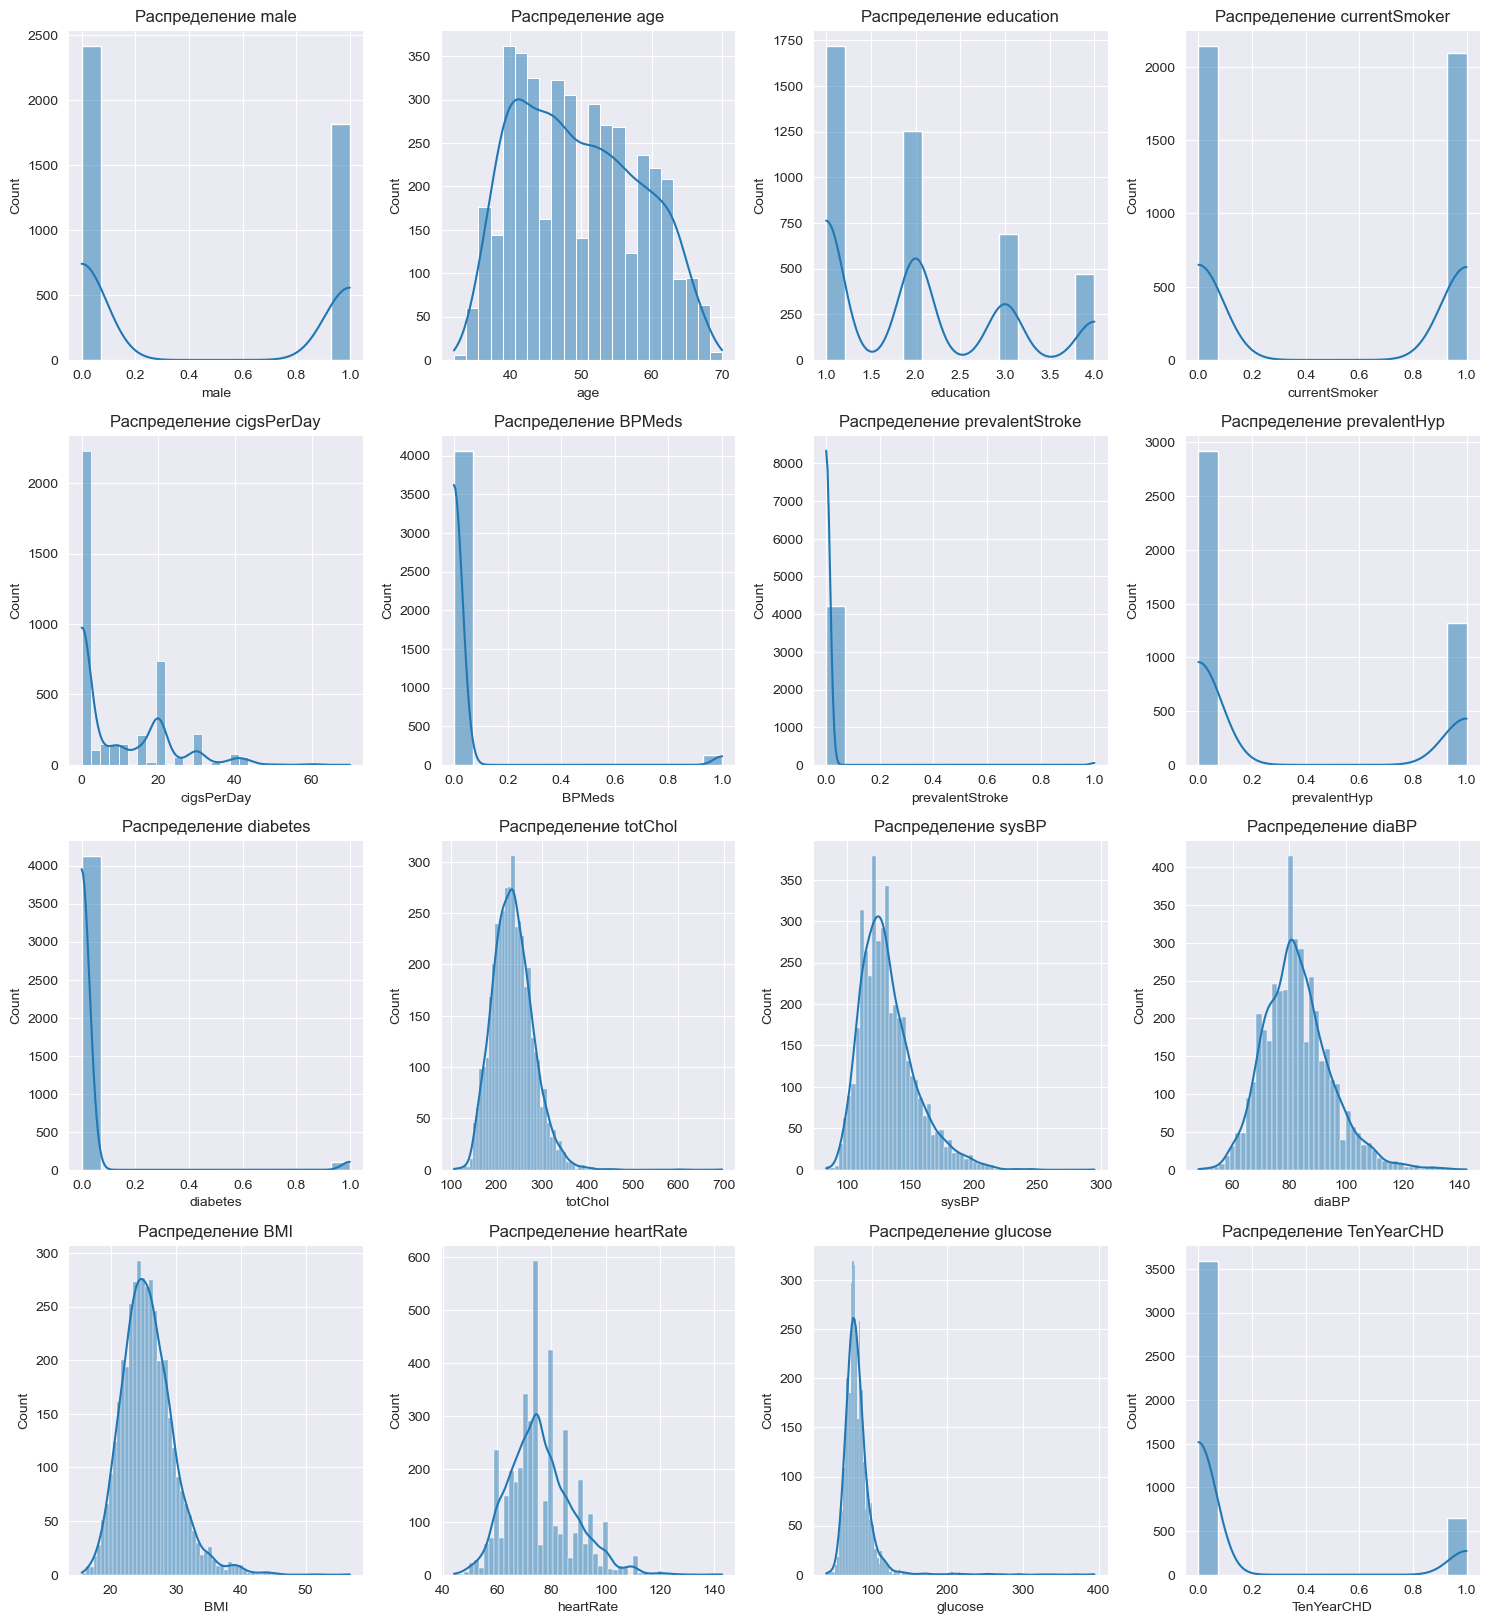

In [6]:
numeric_cols = data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(5, 4, i)
    sns.histplot(data[col], kde=True)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

## 3. Подготовка данных

3.1 Первый способ: заполнение пропусков

In [7]:
data_filled = data.copy()
for col in data_filled.columns:
    if data_filled[col].isnull().any():
        if data_filled[col].dtype in ['float64', 'int64']:
            data_filled[col].fillna(data_filled[col].median(), inplace=True)
        else:
            data_filled[col].fillna(data_filled[col].mode()[0], inplace=True)

3.2 Второй способ: удаление строк с пропусками

In [8]:
data_dropped = data.dropna()

print("\nРазмеры датасетов после обработки:")
print(f"Заполненные данные: {data_filled.shape}")
print(f"Данные без пропусков: {data_dropped.shape}")


Размеры датасетов после обработки:
Заполненные данные: (4240, 16)
Данные без пропусков: (3658, 16)


## 4. Проверка сбалансированности данных

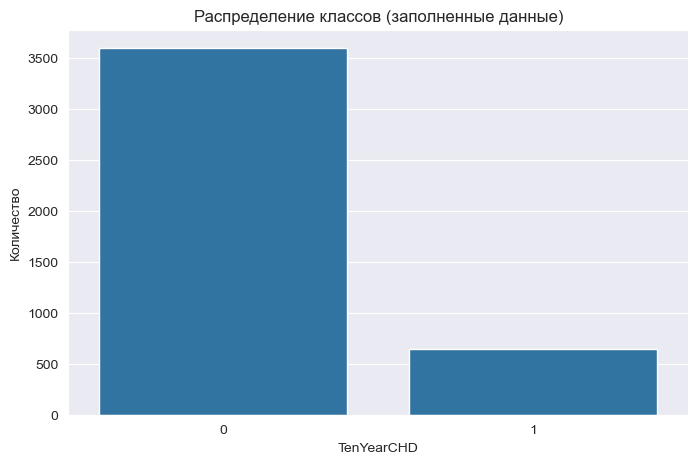


Распределение классов (заполненные данные):
TenYearCHD
0    0.848113
1    0.151887
Name: proportion, dtype: float64


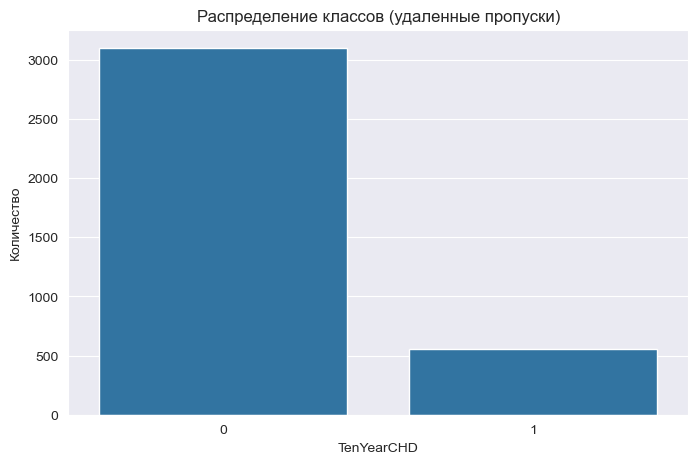


Распределение классов (удаленные пропуски):
TenYearCHD
0    0.847731
1    0.152269
Name: proportion, dtype: float64


In [9]:
def plot_class_balance(df, title):
    plt.figure(figsize=(8, 5))
    sns.countplot(x='TenYearCHD', data=df)
    plt.title(f'Распределение классов ({title})')
    plt.xlabel('TenYearCHD')
    plt.ylabel('Количество')
    plt.show()
    print(f"\nРаспределение классов ({title}):")
    print(df['TenYearCHD'].value_counts(normalize=True))

plot_class_balance(data_filled, "заполненные данные")
plot_class_balance(data_dropped, "удаленные пропуски")

## 5-7. Балансировка данных

In [10]:
def balance_data(X, y, method='smote'):
    if method == 'smote':
        balancer = SMOTE(random_state=42)
    elif method == 'borderline':
        balancer = BorderlineSMOTE(random_state=42)
    elif method == 'svm':
        balancer = SVMSMOTE(random_state=42)
    elif method == 'adasyn':
        balancer = ADASYN(random_state=42)
    elif method == 'kmeans':
        # Пропускаем KMeansSMOTE если примеров слишком мало
        if sum(y == 1) < 10:  # эмпирическое правило
            print("Слишком мало примеров класса 1 для KMeansSMOTE, используем обычный SMOTE")
            balancer = SMOTE(random_state=42)
        else:
            balancer = KMeansSMOTE(
                random_state=42,
                kmeans_estimator=KMeans(n_init='auto'),
                cluster_balance_threshold=0.1  # более низкий порог
            )
    elif method == 'oversample':
        balancer = RandomOverSampler(random_state=42)
    else:
        return X, y
    
    try:
        X_balanced, y_balanced = balancer.fit_resample(X, y)
        return X_balanced, y_balanced
    except RuntimeError as e:
        print(f"Ошибка при балансировке методом {method}: {str(e)}")
        print("Используем обычный SMOTE вместо KMeansSMOTE")
        balancer = SMOTE(random_state=42)
        return balancer.fit_resample(X, y)

# Подготовка данных для балансировки
X_filled = data_filled.drop('TenYearCHD', axis=1)
y_filled = data_filled['TenYearCHD']
X_dropped = data_dropped.drop('TenYearCHD', axis=1)
y_dropped = data_dropped['TenYearCHD']

# Масштабирование признаков
scaler = StandardScaler()
X_filled_scaled = scaler.fit_transform(X_filled)
X_dropped_scaled = scaler.fit_transform(X_dropped)

## 8-12. Моделирование и оценка

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, X_test, y_test, model_name=""):
    y_pred = model.predict(X_test)
    
    # Проверяем, есть ли предсказанные положительные случаи
    if sum(y_pred) == 0:
        print(f"\n{model_name} - Внимание: модель не предсказала ни одного положительного случая!")
        precision = 0.0
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = 0.0
    else:
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Матрица ошибок
    print(f"\n{model_name} - Матрица ошибок:")
    print(confusion_matrix(y_test, y_pred))
    
    # Отчет классификации с zero_division=0
    print(f"\n{model_name} - Отчет классификации:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # ROC-AUC (только если есть оба класса)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        if len(np.unique(y_test)) > 1:
            roc_auc = roc_auc_score(y_test, y_proba)
            print(f"{model_name} - ROC-AUC: {roc_auc:.4f}")
            
            # ROC-кривая
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC={roc_auc:.2f})')
        else:
            print(f"{model_name} - ROC-AUC: невозможно вычислить (только один класс в y_test)")
    else:
        print(f"{model_name} - Модель не поддерживает predict_proba, ROC-AUC недоступен")
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

def train_and_evaluate(X, y, data_type="", balance_method=""):
    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Логистическая регрессия
    lr = LogisticRegression(max_iter=2000, solver='lbfgs')
    lr.fit(X_train, y_train)
    
    # Оценка
    print(f"\n=== Результаты для {data_type} ({balance_method}) ===")
    evaluate_model(lr, X_test, y_test, "Логистическая регрессия")
    
    # KNN с подбором параметров
    knn = GridSearchCV(
        KNeighborsClassifier(),
        {'n_neighbors': range(3, 21, 2)},
        cv=5
    )
    knn.fit(X_train, y_train)
    evaluate_model(knn.best_estimator_, X_test, y_test, "KNN")
    print(f"Лучшие параметры KNN: {knn.best_params_}")
    
    # SVM с подбором параметров
    svm = GridSearchCV(
        SVC(probability=True),
        {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
        cv=3
    )
    svm.fit(X_train, y_train)
    evaluate_model(svm.best_estimator_, X_test, y_test, "SVM")
    print(f"Лучшие параметры SVM: {svm.best_params_}")
    
    # Наивный Байес
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    evaluate_model(nb, X_test, y_test, "Наивный Байес")
    
    # ROC-кривые
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-кривые ({data_type}, {balance_method})')
    plt.legend()
    plt.show()
    
    return {
        'logistic_regression': lr,
        'knn': knn.best_estimator_,
        'svm': svm.best_estimator_,
        'naive_bayes': nb
    }

## Анализ для заполненных данных с разными методами балансировки


=== Результаты для заполненные данные (none) ===

Логистическая регрессия - Матрица ошибок:
[[1067   10]
 [ 174   21]]

Логистическая регрессия - Отчет классификации:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1077
           1       0.68      0.11      0.19       195

    accuracy                           0.86      1272
   macro avg       0.77      0.55      0.55      1272
weighted avg       0.83      0.86      0.81      1272

Логистическая регрессия - ROC-AUC: 0.7154

KNN - Матрица ошибок:
[[1075    2]
 [ 188    7]]

KNN - Отчет классификации:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1077
           1       0.78      0.04      0.07       195

    accuracy                           0.85      1272
   macro avg       0.81      0.52      0.49      1272
weighted avg       0.84      0.85      0.79      1272

KNN - ROC-AUC: 0.6825
Лучшие параметры KNN: {'n_neighbors'

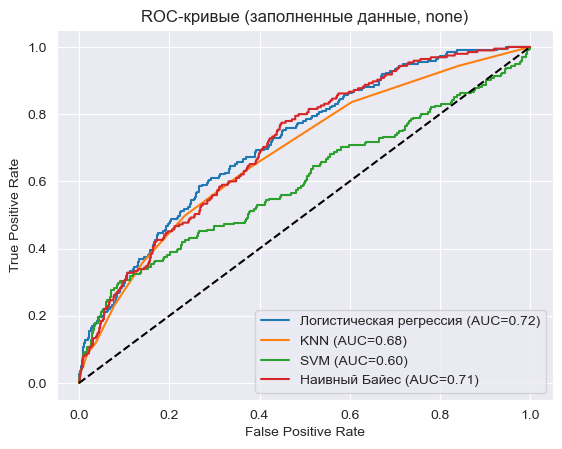


=== Результаты для заполненные данные (smote) ===

Логистическая регрессия - Матрица ошибок:
[[713 372]
 [347 726]]

Логистическая регрессия - Отчет классификации:
              precision    recall  f1-score   support

           0       0.67      0.66      0.66      1085
           1       0.66      0.68      0.67      1073

    accuracy                           0.67      2158
   macro avg       0.67      0.67      0.67      2158
weighted avg       0.67      0.67      0.67      2158

Логистическая регрессия - ROC-AUC: 0.7273

KNN - Матрица ошибок:
[[ 727  358]
 [  31 1042]]

KNN - Отчет классификации:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1085
           1       0.74      0.97      0.84      1073

    accuracy                           0.82      2158
   macro avg       0.85      0.82      0.82      2158
weighted avg       0.85      0.82      0.82      2158

KNN - ROC-AUC: 0.9005
Лучшие параметры KNN: {'n_neighbors': 3

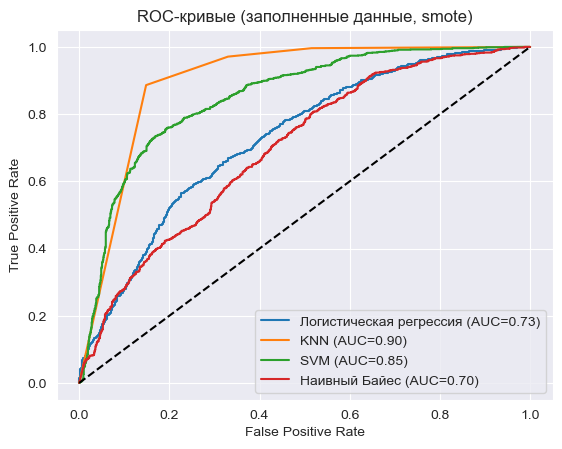


=== Результаты для заполненные данные (borderline) ===

Логистическая регрессия - Матрица ошибок:
[[729 356]
 [286 787]]

Логистическая регрессия - Отчет классификации:
              precision    recall  f1-score   support

           0       0.72      0.67      0.69      1085
           1       0.69      0.73      0.71      1073

    accuracy                           0.70      2158
   macro avg       0.70      0.70      0.70      2158
weighted avg       0.70      0.70      0.70      2158

Логистическая регрессия - ROC-AUC: 0.7588

KNN - Матрица ошибок:
[[ 772  313]
 [  43 1030]]

KNN - Отчет классификации:
              precision    recall  f1-score   support

           0       0.95      0.71      0.81      1085
           1       0.77      0.96      0.85      1073

    accuracy                           0.84      2158
   macro avg       0.86      0.84      0.83      2158
weighted avg       0.86      0.84      0.83      2158

KNN - ROC-AUC: 0.9101
Лучшие параметры KNN: {'n_neighbor

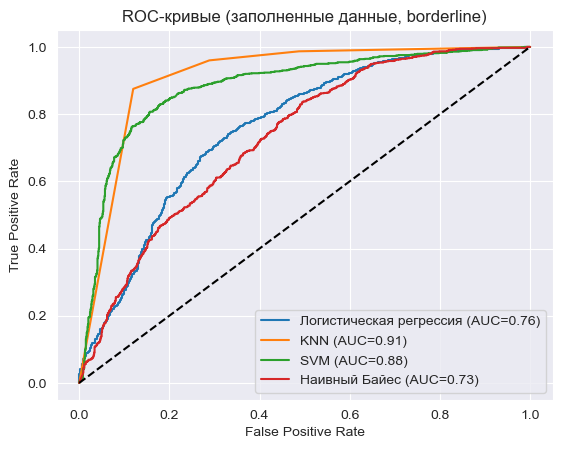


=== Результаты для заполненные данные (svm) ===

Логистическая регрессия - Матрица ошибок:
[[846 239]
 [302 771]]

Логистическая регрессия - Отчет классификации:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1085
           1       0.76      0.72      0.74      1073

    accuracy                           0.75      2158
   macro avg       0.75      0.75      0.75      2158
weighted avg       0.75      0.75      0.75      2158

Логистическая регрессия - ROC-AUC: 0.8382

KNN - Матрица ошибок:
[[ 824  261]
 [  67 1006]]

KNN - Отчет классификации:
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1085
           1       0.79      0.94      0.86      1073

    accuracy                           0.85      2158
   macro avg       0.86      0.85      0.85      2158
weighted avg       0.86      0.85      0.85      2158

KNN - ROC-AUC: 0.9118
Лучшие параметры KNN: {'n_neighbors': 3}


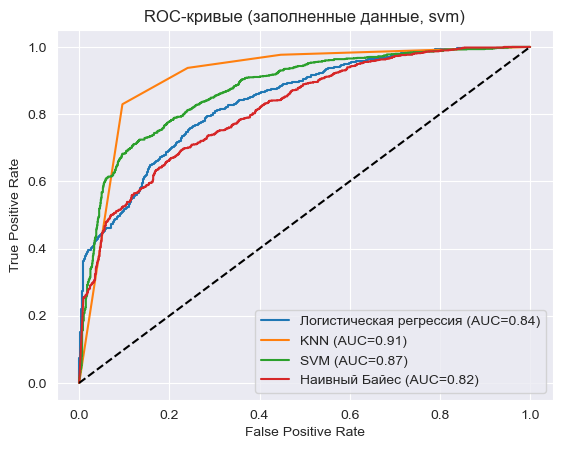


=== Результаты для заполненные данные (adasyn) ===

Логистическая регрессия - Матрица ошибок:
[[658 419]
 [348 777]]

Логистическая регрессия - Отчет классификации:
              precision    recall  f1-score   support

           0       0.65      0.61      0.63      1077
           1       0.65      0.69      0.67      1125

    accuracy                           0.65      2202
   macro avg       0.65      0.65      0.65      2202
weighted avg       0.65      0.65      0.65      2202

Логистическая регрессия - ROC-AUC: 0.7012

KNN - Матрица ошибок:
[[ 705  372]
 [  11 1114]]

KNN - Отчет классификации:
              precision    recall  f1-score   support

           0       0.98      0.65      0.79      1077
           1       0.75      0.99      0.85      1125

    accuracy                           0.83      2202
   macro avg       0.87      0.82      0.82      2202
weighted avg       0.86      0.83      0.82      2202

KNN - ROC-AUC: 0.9076
Лучшие параметры KNN: {'n_neighbors': 

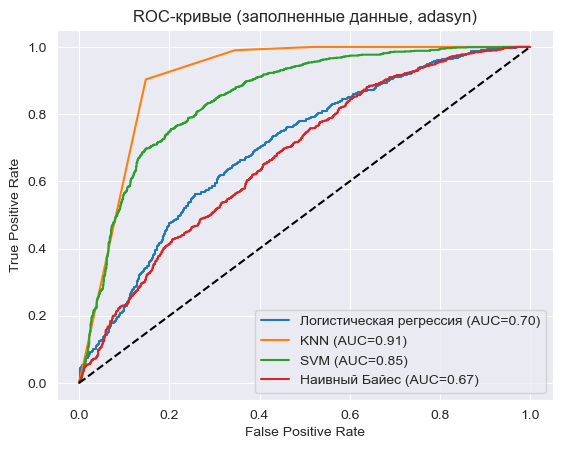


=== Результаты для заполненные данные (kmeans) ===

Логистическая регрессия - Матрица ошибок:
[[875 200]
 [129 955]]

Логистическая регрессия - Отчет классификации:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1075
           1       0.83      0.88      0.85      1084

    accuracy                           0.85      2159
   macro avg       0.85      0.85      0.85      2159
weighted avg       0.85      0.85      0.85      2159

Логистическая регрессия - ROC-AUC: 0.8978

KNN - Матрица ошибок:
[[935 140]
 [131 953]]

KNN - Отчет классификации:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1075
           1       0.87      0.88      0.88      1084

    accuracy                           0.87      2159
   macro avg       0.87      0.87      0.87      2159
weighted avg       0.87      0.87      0.87      2159

KNN - ROC-AUC: 0.9144
Лучшие параметры KNN: {'n_neighbors': 3}



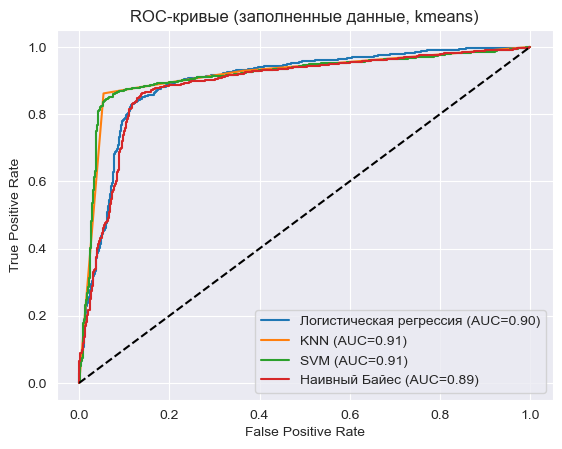


=== Результаты для заполненные данные (oversample) ===

Логистическая регрессия - Матрица ошибок:
[[718 367]
 [349 724]]

Логистическая регрессия - Отчет классификации:
              precision    recall  f1-score   support

           0       0.67      0.66      0.67      1085
           1       0.66      0.67      0.67      1073

    accuracy                           0.67      2158
   macro avg       0.67      0.67      0.67      2158
weighted avg       0.67      0.67      0.67      2158

Логистическая регрессия - ROC-AUC: 0.7224

KNN - Матрица ошибок:
[[ 770  315]
 [  55 1018]]

KNN - Отчет классификации:
              precision    recall  f1-score   support

           0       0.93      0.71      0.81      1085
           1       0.76      0.95      0.85      1073

    accuracy                           0.83      2158
   macro avg       0.85      0.83      0.83      2158
weighted avg       0.85      0.83      0.83      2158

KNN - ROC-AUC: 0.9022
Лучшие параметры KNN: {'n_neighbor

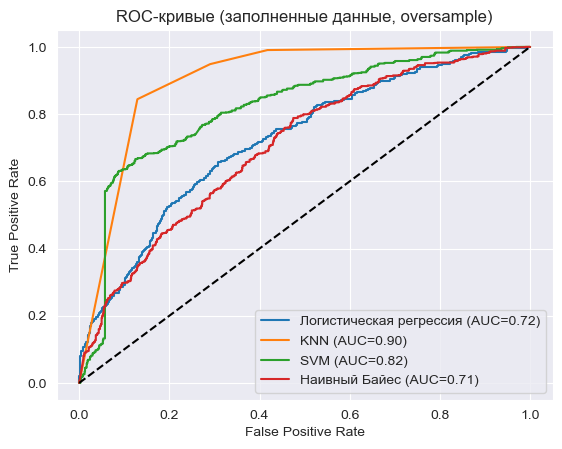

In [12]:
methods = ['none', 'smote', 'borderline', 'svm', 'adasyn', 'kmeans', 'oversample']
results_filled = {}

for method in methods:
    X_bal, y_bal = balance_data(X_filled_scaled, y_filled, method)
    results_filled[method] = train_and_evaluate(
        X_bal, y_bal, 
        data_type="заполненные данные", 
        balance_method=method
    )


## Анализ для данных без пропусков с разными методами балансировки


=== Результаты для данные без пропусков (none) ===

Логистическая регрессия - Матрица ошибок:
[[918   4]
 [164  12]]

Логистическая регрессия - Отчет классификации:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       922
           1       0.75      0.07      0.12       176

    accuracy                           0.85      1098
   macro avg       0.80      0.53      0.52      1098
weighted avg       0.83      0.85      0.79      1098

Логистическая регрессия - ROC-AUC: 0.7464

KNN - Внимание: модель не предсказала ни одного положительного случая!

KNN - Матрица ошибок:
[[922   0]
 [176   0]]

KNN - Отчет классификации:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       922
           1       0.00      0.00      0.00       176

    accuracy                           0.84      1098
   macro avg       0.42      0.50      0.46      1098
weighted avg       0.71      0.84      0.77    

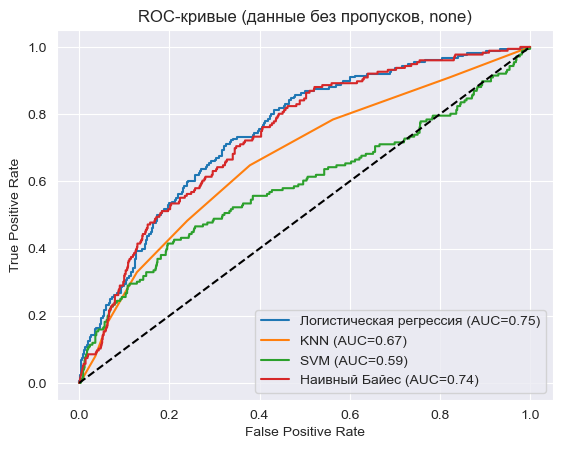


=== Результаты для данные без пропусков (smote) ===

Логистическая регрессия - Матрица ошибок:
[[637 301]
 [281 642]]

Логистическая регрессия - Отчет классификации:
              precision    recall  f1-score   support

           0       0.69      0.68      0.69       938
           1       0.68      0.70      0.69       923

    accuracy                           0.69      1861
   macro avg       0.69      0.69      0.69      1861
weighted avg       0.69      0.69      0.69      1861

Логистическая регрессия - ROC-AUC: 0.7480

KNN - Матрица ошибок:
[[614 324]
 [ 14 909]]

KNN - Отчет классификации:
              precision    recall  f1-score   support

           0       0.98      0.65      0.78       938
           1       0.74      0.98      0.84       923

    accuracy                           0.82      1861
   macro avg       0.86      0.82      0.81      1861
weighted avg       0.86      0.82      0.81      1861

KNN - ROC-AUC: 0.9036
Лучшие параметры KNN: {'n_neighbors': 3}


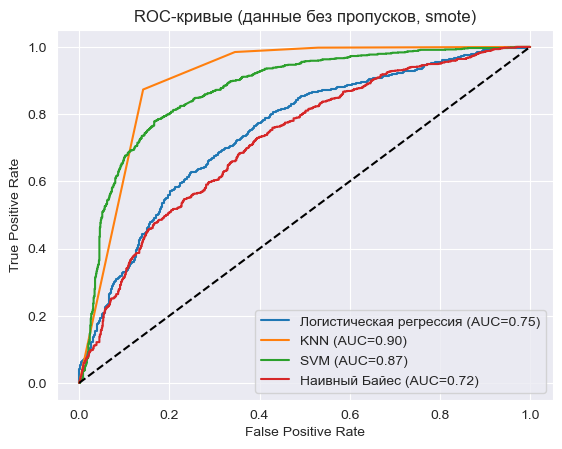


=== Результаты для данные без пропусков (borderline) ===

Логистическая регрессия - Матрица ошибок:
[[669 269]
 [217 706]]

Логистическая регрессия - Отчет классификации:
              precision    recall  f1-score   support

           0       0.76      0.71      0.73       938
           1       0.72      0.76      0.74       923

    accuracy                           0.74      1861
   macro avg       0.74      0.74      0.74      1861
weighted avg       0.74      0.74      0.74      1861

Логистическая регрессия - ROC-AUC: 0.7933

KNN - Матрица ошибок:
[[681 257]
 [ 37 886]]

KNN - Отчет классификации:
              precision    recall  f1-score   support

           0       0.95      0.73      0.82       938
           1       0.78      0.96      0.86       923

    accuracy                           0.84      1861
   macro avg       0.86      0.84      0.84      1861
weighted avg       0.86      0.84      0.84      1861

KNN - ROC-AUC: 0.9055
Лучшие параметры KNN: {'n_neighbors'

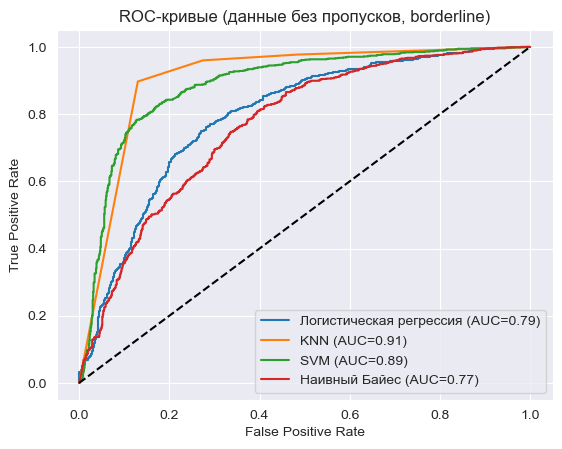


=== Результаты для данные без пропусков (svm) ===

Логистическая регрессия - Матрица ошибок:
[[755 183]
 [243 680]]

Логистическая регрессия - Отчет классификации:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       938
           1       0.79      0.74      0.76       923

    accuracy                           0.77      1861
   macro avg       0.77      0.77      0.77      1861
weighted avg       0.77      0.77      0.77      1861

Логистическая регрессия - ROC-AUC: 0.8562

KNN - Матрица ошибок:
[[717 221]
 [ 61 862]]

KNN - Отчет классификации:
              precision    recall  f1-score   support

           0       0.92      0.76      0.84       938
           1       0.80      0.93      0.86       923

    accuracy                           0.85      1861
   macro avg       0.86      0.85      0.85      1861
weighted avg       0.86      0.85      0.85      1861

KNN - ROC-AUC: 0.9096
Лучшие параметры KNN: {'n_neighbors': 3}

S

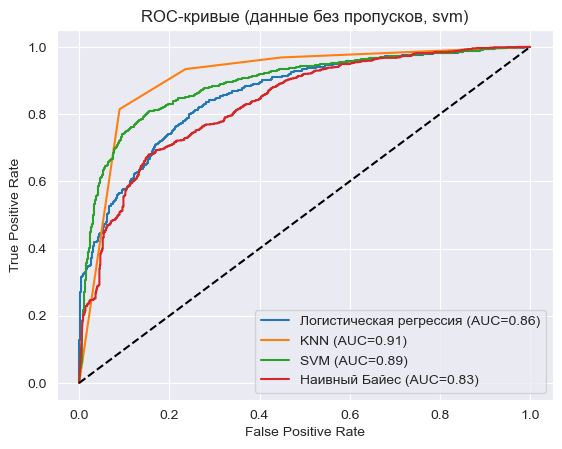


=== Результаты для данные без пропусков (adasyn) ===

Логистическая регрессия - Матрица ошибок:
[[626 309]
 [296 642]]

Логистическая регрессия - Отчет классификации:
              precision    recall  f1-score   support

           0       0.68      0.67      0.67       935
           1       0.68      0.68      0.68       938

    accuracy                           0.68      1873
   macro avg       0.68      0.68      0.68      1873
weighted avg       0.68      0.68      0.68      1873

Логистическая регрессия - ROC-AUC: 0.7349

KNN - Матрица ошибок:
[[633 302]
 [ 10 928]]

KNN - Отчет классификации:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80       935
           1       0.75      0.99      0.86       938

    accuracy                           0.83      1873
   macro avg       0.87      0.83      0.83      1873
weighted avg       0.87      0.83      0.83      1873

KNN - ROC-AUC: 0.9109
Лучшие параметры KNN: {'n_neighbors': 3}

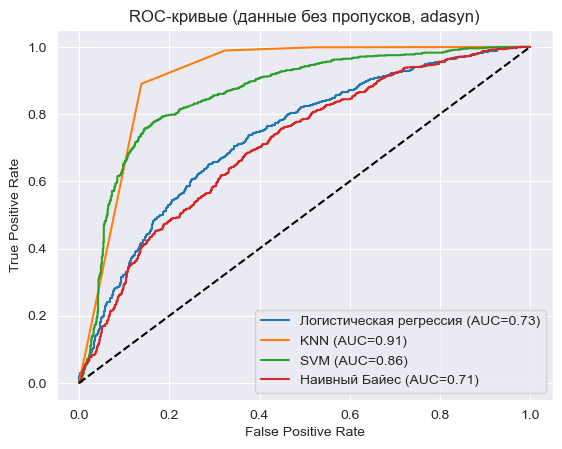


=== Результаты для данные без пропусков (kmeans) ===

Логистическая регрессия - Матрица ошибок:
[[737 193]
 [145 787]]

Логистическая регрессия - Отчет классификации:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       930
           1       0.80      0.84      0.82       932

    accuracy                           0.82      1862
   macro avg       0.82      0.82      0.82      1862
weighted avg       0.82      0.82      0.82      1862

Логистическая регрессия - ROC-AUC: 0.8796

KNN - Матрица ошибок:
[[769 161]
 [ 92 840]]

KNN - Отчет классификации:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       930
           1       0.84      0.90      0.87       932

    accuracy                           0.86      1862
   macro avg       0.87      0.86      0.86      1862
weighted avg       0.87      0.86      0.86      1862

KNN - ROC-AUC: 0.9081
Лучшие параметры KNN: {'n_neighbors': 3}

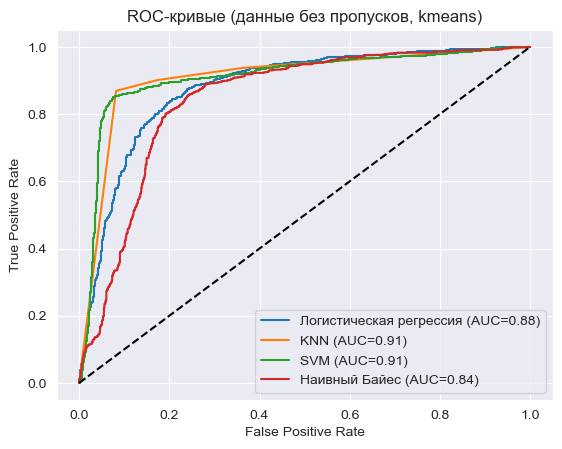


=== Результаты для данные без пропусков (oversample) ===

Логистическая регрессия - Матрица ошибок:
[[648 290]
 [293 630]]

Логистическая регрессия - Отчет классификации:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       938
           1       0.68      0.68      0.68       923

    accuracy                           0.69      1861
   macro avg       0.69      0.69      0.69      1861
weighted avg       0.69      0.69      0.69      1861

Логистическая регрессия - ROC-AUC: 0.7407

KNN - Матрица ошибок:
[[683 255]
 [ 63 860]]

KNN - Отчет классификации:
              precision    recall  f1-score   support

           0       0.92      0.73      0.81       938
           1       0.77      0.93      0.84       923

    accuracy                           0.83      1861
   macro avg       0.84      0.83      0.83      1861
weighted avg       0.84      0.83      0.83      1861

KNN - ROC-AUC: 0.8956
Лучшие параметры KNN: {'n_neighbors'

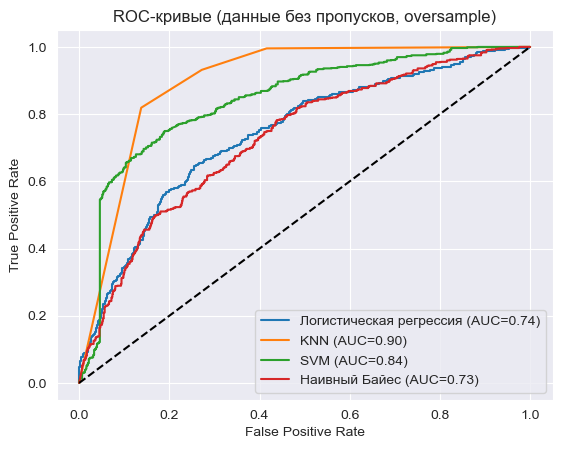

In [13]:
results_dropped = {}

for method in methods:
    X_bal, y_bal = balance_data(X_dropped_scaled, y_dropped, method)
    results_dropped[method] = train_and_evaluate(
        X_bal, y_bal, 
        data_type="данные без пропусков", 
        balance_method=method
    )

## 11. Анализ логистической регрессии с statsmodels

In [14]:
def logistic_regression_statsmodels(X, y, feature_names=None):
    """
    X - массив numpy или pandas DataFrame
    y - целевая переменная
    feature_names - список имен признаков (если X - numpy array)
    """
    # Если X - numpy array и заданы имена признаков
    if isinstance(X, np.ndarray) and feature_names is not None:
        X_const = sm.add_constant(X)
        features = ['const'] + feature_names
    # Если X - DataFrame
    elif hasattr(X, 'columns'):
        X_const = sm.add_constant(X)
        features = ['const'] + list(X.columns)
    else:
        raise ValueError("X должен быть pandas DataFrame или numpy array с указанными feature_names")
    
    # Логистическая регрессия
    model = sm.Logit(y, X_const)
    result = model.fit()
    print(result.summary())
    
    # Расчет VIF для мультиколлинеарности
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(X_const, i) for i in range(X_const.shape[1])]
    print("\nVIF факторы:")
    print(vif_data)

# Получаем имена признаков из исходных данных
feature_names = data_filled.drop('TenYearCHD', axis=1).columns.tolist()

print("\nАнализ для заполненных данных:")
logistic_regression_statsmodels(X_filled_scaled, y_filled, feature_names=feature_names)

print("\nАнализ для данных без пропусков:")
logistic_regression_statsmodels(X_dropped_scaled, y_dropped, feature_names=feature_names)


Анализ для заполненных данных:
Optimization terminated successfully.
         Current function value: 0.378434
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 4240
Model:                          Logit   Df Residuals:                     4224
Method:                           MLE   Df Model:                           15
Date:                Tue, 13 May 2025   Pseudo R-squ.:                  0.1116
Time:                        10:20:05   Log-Likelihood:                -1604.6
converged:                       True   LL-Null:                       -1806.1
Covariance Type:            nonrobust   LLR p-value:                 1.550e-76
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9774      0.052    -37.801      0.000      -2.080      -1.8

## 13. Анализ несбалансированных данных


=== Анализ несбалансированных заполненных данных ===

=== Результаты для несбалансированные заполненные (без балансировки) ===

Логистическая регрессия - Матрица ошибок:
[[1067   10]
 [ 174   21]]

Логистическая регрессия - Отчет классификации:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1077
           1       0.68      0.11      0.19       195

    accuracy                           0.86      1272
   macro avg       0.77      0.55      0.55      1272
weighted avg       0.83      0.86      0.81      1272

Логистическая регрессия - ROC-AUC: 0.7154

KNN - Матрица ошибок:
[[1075    2]
 [ 188    7]]

KNN - Отчет классификации:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1077
           1       0.78      0.04      0.07       195

    accuracy                           0.85      1272
   macro avg       0.81      0.52      0.49      1272
weighted avg       0.84      0.85  

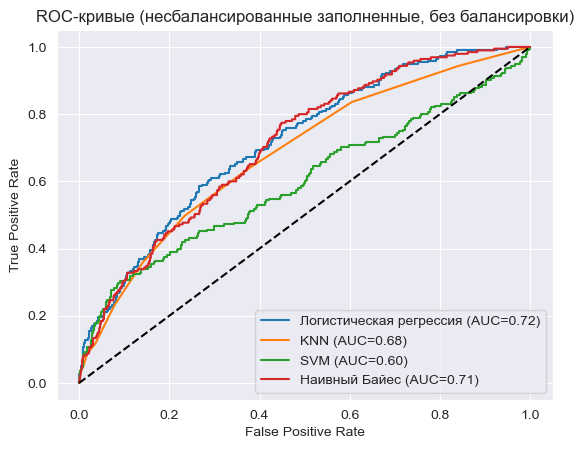


=== Анализ несбалансированных данных без пропусков ===

=== Результаты для несбалансированные без пропусков (без балансировки) ===

Логистическая регрессия - Матрица ошибок:
[[918   4]
 [164  12]]

Логистическая регрессия - Отчет классификации:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       922
           1       0.75      0.07      0.12       176

    accuracy                           0.85      1098
   macro avg       0.80      0.53      0.52      1098
weighted avg       0.83      0.85      0.79      1098

Логистическая регрессия - ROC-AUC: 0.7464

KNN - Внимание: модель не предсказала ни одного положительного случая!

KNN - Матрица ошибок:
[[922   0]
 [176   0]]

KNN - Отчет классификации:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       922
           1       0.00      0.00      0.00       176

    accuracy                           0.84      1098
   macro avg       0.

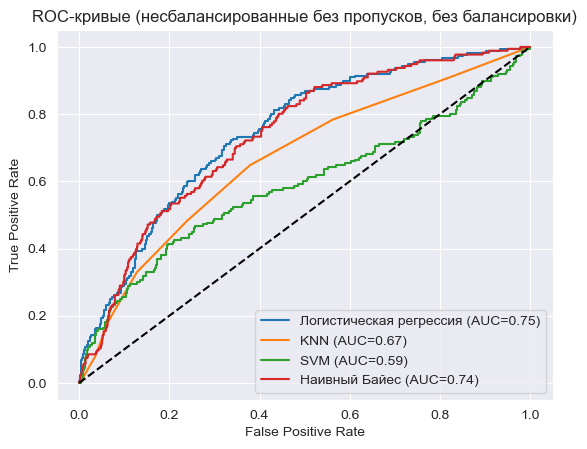

{'logistic_regression': LogisticRegression(max_iter=2000),
 'knn': KNeighborsClassifier(n_neighbors=19),
 'svm': SVC(C=0.1, probability=True),
 'naive_bayes': GaussianNB()}

In [15]:
print("\n=== Анализ несбалансированных заполненных данных ===")
train_and_evaluate(X_filled_scaled, y_filled, "несбалансированные заполненные", "без балансировки")

print("\n=== Анализ несбалансированных данных без пропусков ===")
train_and_evaluate(X_dropped_scaled, y_dropped, "несбалансированные без пропусков", "без балансировки")

## 14. Сравнение моделей и выводы

/opt/anaconda3/envs/MOADJupyter/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/MOADJupyter/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/MOADJupyter/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


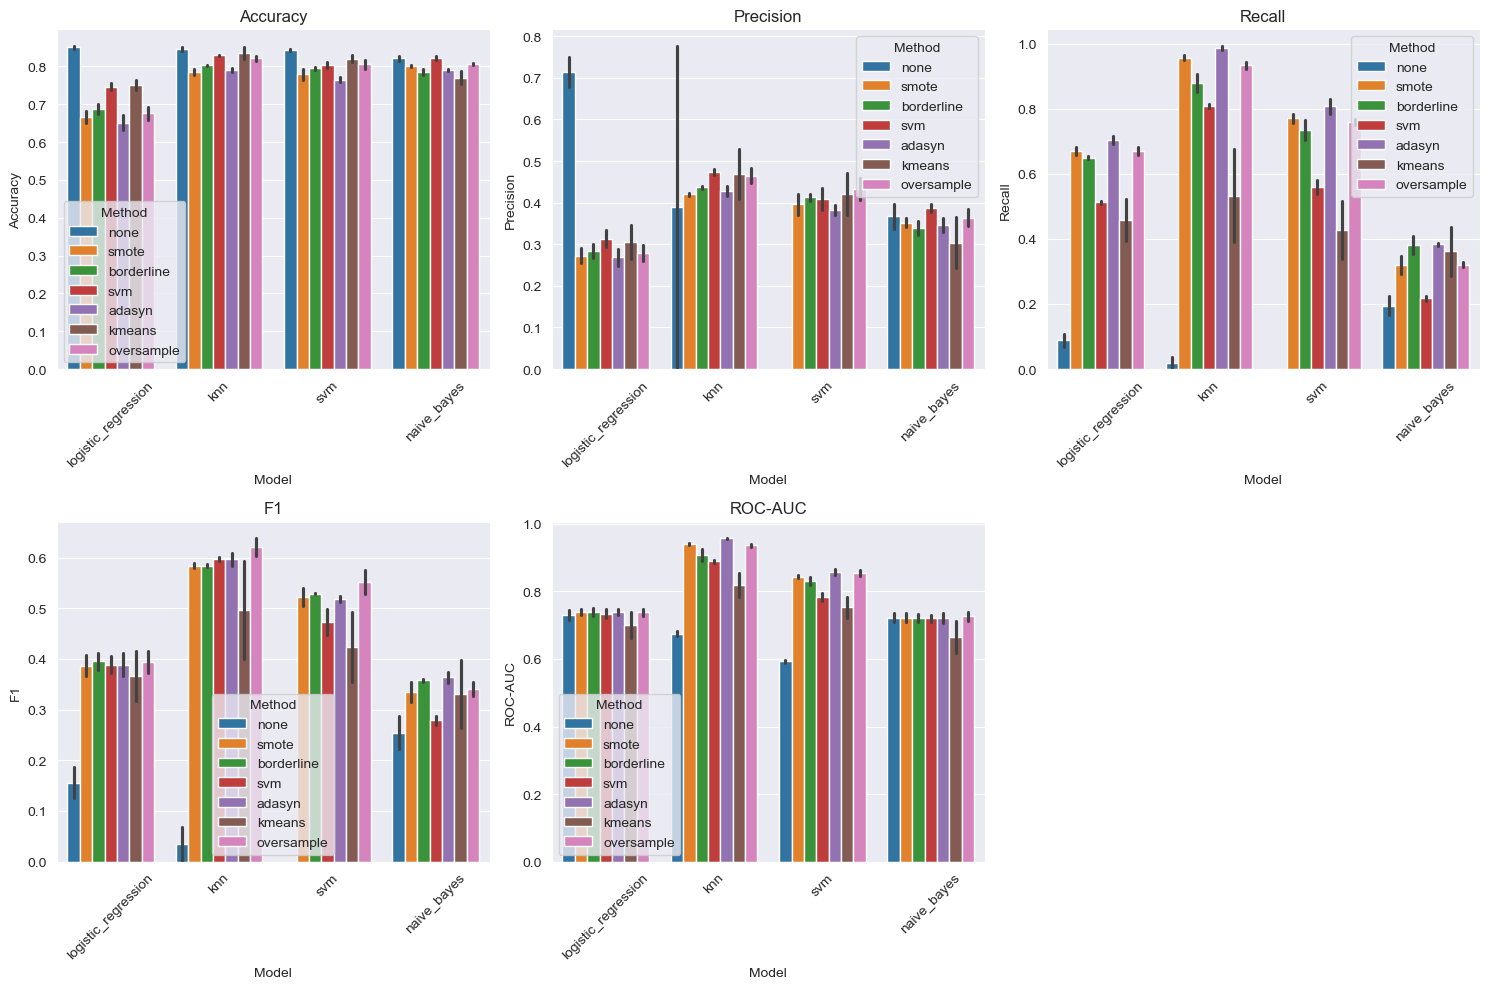


Лучшие модели по ROC-AUC:
       Data      Method Model  Accuracy  Precision    Recall        F1  \
17  dropped      adasyn   knn  0.795993   0.439698  0.994318  0.609756   
17   filled      adasyn   knn  0.785377   0.415217  0.979487  0.583206   
5    filled       smote   knn  0.793239   0.423423  0.964103  0.588419   
25  dropped  oversample   knn  0.828780   0.482558  0.943182  0.638462   
5   dropped       smote   knn  0.778689   0.416459  0.948864  0.578856   
25   filled  oversample   knn  0.813679   0.447761  0.923077  0.603015   
9    filled  borderline   knn  0.804245   0.433824  0.907692  0.587065   
13   filled         svm   knn  0.828616   0.466276  0.815385  0.593284   
9   dropped  borderline   knn  0.802368   0.439883  0.852273  0.580271   
13  dropped         svm   knn  0.829690   0.481229  0.801136  0.601279   

     ROC-AUC  
17  0.958320  
17  0.956148  
5   0.942785  
25  0.941580  
5   0.936714  
25  0.932112  
9   0.926434  
13  0.893184  
9   0.891038  
13  0.88

In [16]:
def compare_results(results_dict, data_name):
    metrics = []
    for method, models in results_dict.items():
        for model_name, model in models.items():
            X_train, X_test, y_train, y_test = train_test_split(
                X_filled_scaled if "filled" in data_name else X_dropped_scaled,
                y_filled if "filled" in data_name else y_dropped,
                test_size=0.3, random_state=42
            )
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
            
            metrics.append({
                'Data': data_name,
                'Method': method,
                'Model': model_name,
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred),
                'Recall': recall_score(y_test, y_pred),
                'F1': f1_score(y_test, y_pred),
                'ROC-AUC': roc_auc_score(y_test, y_proba)
            })
    return pd.DataFrame(metrics)

# Сравнение результатов
metrics_filled = compare_results(results_filled, "filled")
metrics_dropped = compare_results(results_dropped, "dropped")
all_metrics = pd.concat([metrics_filled, metrics_dropped])

# Визуализация сравнения
plt.figure(figsize=(15, 10))
for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'], 1):
    plt.subplot(2, 3, i)
    sns.barplot(data=all_metrics, x='Model', y=metric, hue='Method')
    plt.title(metric)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Вывод лучших моделей
print("\nЛучшие модели по ROC-AUC:")
print(all_metrics.sort_values('ROC-AUC', ascending=False).head(10))